In [89]:
import os
import sys

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Feature importances via Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split

from scipy.cluster.hierarchy import linkage, cut_tree

In [4]:
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [46]:
from global_config import *
from src.utils.helpers import get_emotion_abrs_from_ids

## Paths

In [83]:
input_path = os.path.join(ROOT_DIR,'files/tests/preprocessing/dataset_creation/video_data_functionals_A220.npz')
output_path = os.path.join(ROOT_DIR,'files/out/functionals/unsupervised_learning/video')

In [84]:
npz_file = np.load(input_path, allow_pickle=True)
X = npz_file['x']
y = npz_file['y']
col_names = npz_file['col_names']

In [71]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## K Means

### CH index

In [28]:
def calculateBCSS(X, km):
    _, label_counts = np.unique(km.labels_, return_counts = True)
    diff_cluster_sq = np.linalg.norm(km.cluster_centers_ - np.mean(X,axis=0), axis=1)**2
    return sum(label_counts * diff_cluster_sq)

# Initialize variables
results = []
K_max = 100
K = range(2,K_max)
for k in tqdm(K):
    km = KMeans(n_clusters=k, n_init=100, random_state=seed)
    km = km.fit(X)
    WCSS_k = km.inertia_
    BCSS_k = calculateBCSS(X,km)
    CH_k = (BCSS_k/WCSS_k)*((len(X)-k)/(k-1))
    results.append([k,WCSS_k,BCSS_k,CH_k])

results_df = pd.DataFrame(results, columns=['k','WCSS','BCSS','CH_index'])
results_df.to_csv(os.path.join(output_path,'results','ch_kmeans_before_dim_red.csv'), index=None, header=True)

100%|███████████████████████████████████████████| 98/98 [04:42<00:00,  2.89s/it]


NameError: name 'output_path' is not defined

In [30]:
results_df.to_csv(os.path.join(output_path,'results','ch_kmeans_before_dim_red.csv'), index=None, header=True)

In [34]:
results_df

,k,WCSS,BCSS,CH_index
0,2,799.324106,202.032366,88.463900
1,3,730.276110,271.080363,64.774847
2,4,684.197539,317.158934,53.771658
3,5,650.374679,350.981794,46.815584
4,6,619.040254,382.316219,42.737580
...,...,...,...,...
93,95,239.237217,762.119256,8.709625
94,96,236.738698,764.617774,8.703451
95,97,235.380871,765.975602,8.643959
96,98,233.037490,768.318983,8.633318


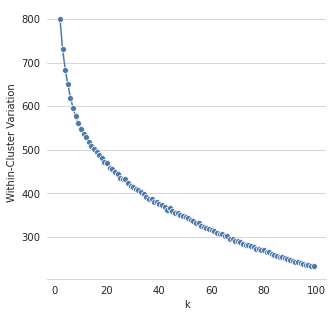

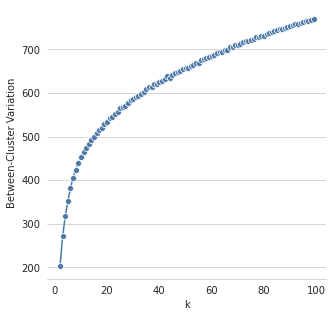

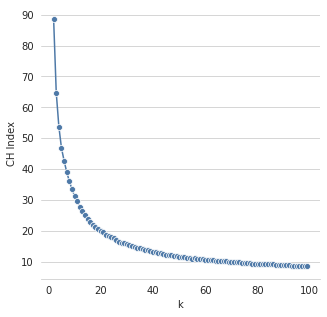

In [32]:
results_df = pd.read_csv(os.path.join(output_path,'results','ch_kmeans_before_dim_red.csv'))

plt.figure(figsize=[5,5])
sns.lineplot('k', 'WCSS', marker='o', data=results_df, color=blue_rgb)
plt.xlabel('k')
plt.ylabel('Within-Cluster Variation')
plt.grid(axis='x')
plt.savefig(os.path.join(output_path,'charts','ch_wcss_kmeans_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

plt.figure(figsize=[5,5])
sns.lineplot('k', 'BCSS', marker='o', data=results_df, color=blue_rgb)
plt.xlabel('k')
plt.ylabel('Between-Cluster Variation')
plt.grid(axis='x')
plt.savefig(os.path.join(output_path,'charts','ch_bcss_kmeans_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

plt.figure(figsize=[5,5])
sns.lineplot('k', 'CH_index', marker='o', data=results_df, color=blue_rgb)
plt.xlabel('k')
plt.ylabel('CH Index')
plt.grid(axis='x')
plt.savefig(os.path.join(output_path,'charts','report_ch_kmeans_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

### Average Silhoutte Value

In [37]:
# Initialize variables
results = []          
K_max = 100
K = range(2,K_max)
for k in tqdm(K):
    km = KMeans(n_clusters=k, n_init=100, random_state=seed)
    cluster_labels = km.fit_predict(X)
    silhouette_avg_k = silhouette_score(X, cluster_labels)
    results.append([k,silhouette_avg_k])
results_df = pd.DataFrame(results,columns=['k','silhouette_avg'])
results_df.to_csv(os.path.join(output_path,'results','silhouette_kmeans_before_dim_red.csv'), index=None, header=True)

100%|███████████████████████████████████████████| 98/98 [04:22<00:00,  2.68s/it]


In [39]:
results_df

,k,silhouette_avg
0,2,0.197917
1,3,0.167465
2,4,0.112945
3,5,0.114033
4,6,0.114068
...,...,...
93,95,0.061303
94,96,0.057604
95,97,0.054020
96,98,0.062711


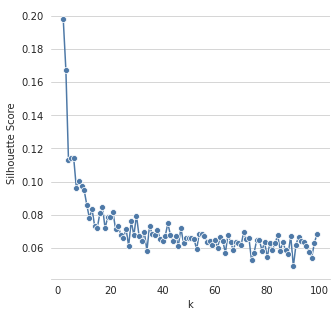

In [38]:
results_df = pd.read_csv(os.path.join(output_path,'results','silhouette_kmeans_before_dim_red.csv'))

plt.figure(figsize=(5,5))
sns.lineplot(x='k', y='silhouette_avg', marker='o', data=results_df, color=blue_rgb)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.grid(axis='x')
plt.savefig(os.path.join(output_path,'charts','report_silhouette_kmeans_before_dim_red.svg'), bbox_inches = 'tight')

### Result

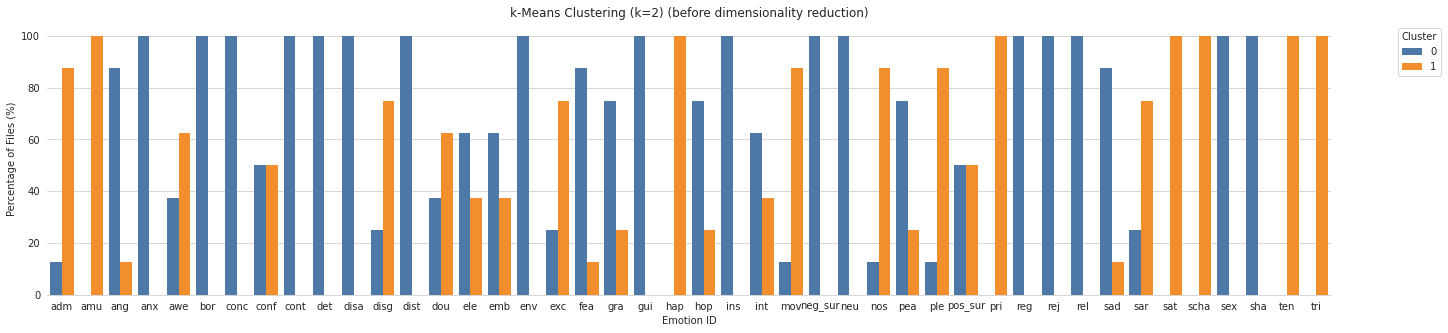

In [76]:
km = KMeans(n_clusters=2, n_init=100, random_state=seed)
labels = km.fit_predict(X)

tmp_df = pd.DataFrame(data=X)
tmp_df['cluster'] = labels
tmp_df["emotion_id"] = get_emotion_abrs_from_ids(y)

emotion_cluster = tmp_df.groupby(['emotion_id','cluster']).agg({0:'count'}).rename(columns={0:'counts'})
perc_df = emotion_cluster.groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index().rename(columns={'counts':'percentage'})

plt.figure(figsize=[23,5])
sns.barplot(x='emotion_id', y='percentage', hue='cluster', data=perc_df, saturation=sns_saturation, palette=palette_def)
plt.xlabel('Emotion ID')
plt.ylabel('Percentage of Files (%)')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.09, 1))
plt.savefig(os.path.join(output_path,'charts','report_k_kmeans_k_2_before_dim_red.svg'), bbox_inches = 'tight')
plt.title('k-Means Clustering (k=2) (before dimensionality reduction)')
plt.savefig(os.path.join(output_path,'charts','k_kmeans_k_2_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

In [85]:
XX = tmp_df.drop(columns=['emotion_id','cluster'])
yy = tmp_df.cluster

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# MODEL INTERPRETATION VIA DECISION TREE -------------------------------------------------------------------------------------------------------------------------------------------------------------
clf = DecisionTreeClassifier(random_state=0)
clf.fit(XX,yy)

dot_data = export_graphviz(clf,
                           out_file = os.path.join(output_path,'others','report_tree_kmeans_k_2_before_dim_red.dot'),
                           feature_names = col_names,
                           filled = False,
                           class_names = ['0','1'],
                           max_depth = 3)

! dot -Nfontname=Sans-Serif -Efontname=Sans-Serif -Tsvg ../../../files/out/functionals/unsupervised_learning/video/others/report_tree_kmeans_k_2_before_dim_red.dot -o ../../../files/out/functionals/unsupervised_learning/video/others/report_tree_kmeans_k_2_before_dim_red.svg
! dot -Nfontname=Sans-Serif -Efontname=Sans-Serif -Tpng ../../../files/out/functionals/unsupervised_learning/video/others/report_tree_kmeans_k_2_before_dim_red.dot -o ../../../files/out/functionals/unsupervised_learning/video/others/report_tree_kmeans_k_2_before_dim_red.png 

In [86]:
df_tmp = emotion_cluster.reset_index()
idx = df_tmp.groupby(['emotion_id'])['counts'].transform(max) == df_tmp['counts']
df_tmp[idx]

,emotion_id,cluster,counts
1,adm,1,7
2,amu,1,8
3,ang,0,7
5,anx,0,8
7,awe,1,5
8,bor,0,8
9,conc,0,8
10,conf,0,4
11,conf,1,4
12,cont,0,8


## Hierachial Clustering

### CH index

In [92]:
def getCentroids(X,clusters,labels):
    X_tmp = pd.DataFrame(data=X)
    X_tmp['cluster'] = clusters    
    #centroids = {l: X_tmp.loc[X_tmp['cluster'] == l].mean().values for l in labels}
    centroids = [X_tmp.drop(columns='cluster').loc[X_tmp['cluster'] == l].mean().values for l in labels]
    return centroids

def calculateWCSS(X, clusters):
    labels, label_counts = np.unique(clusters, return_counts = True)
    X_tmp = pd.DataFrame(data=X)
    X_tmp['cluster'] = clusters
    centroids = getCentroids(X,clusters,labels)
    diff_cluster_sq = [np.linalg.norm(X_tmp.drop(columns='cluster').loc[X_tmp['cluster'] == l] - centroids[l])**2 for l in labels]
    return sum(diff_cluster_sq)

def calculateBCSS(X, clusters):
    labels, label_counts = np.unique(clusters, return_counts = True)
    diff_cluster_sq = np.linalg.norm(getCentroids(X,clusters,labels) - np.mean(X,axis=0), axis=1)**2
    return sum(label_counts * diff_cluster_sq)



K_max = 100
K = range(2,K_max)
method_values = ['single','complete','weighted']
results = []
for method in tqdm(method_values):
    links = linkage(X, method=method, metric='cityblock')
    
    for k in K:
        clusters = cut_tree(links, n_clusters=k)
        WCSS_k = calculateWCSS(X, clusters)
        BCSS_k = calculateBCSS(X, clusters)
        CH_k = (BCSS_k/WCSS_k)*((len(X)-k)/(k-1))
        results.append([method,
                        k,
                        WCSS_k,
                        BCSS_k,
                        CH_k]
                      )
results_df = pd.DataFrame(results,columns=['method','k','WCSS','BCSS','CH_index'])
results_df.to_csv(os.path.join(output_path,'results','ch_hier_clust_before_dim_red.csv'), index=None, header=True)

100%|█████████████████████████████████████████████| 3/3 [01:00<00:00, 20.33s/it]


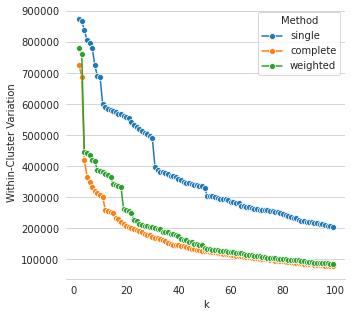

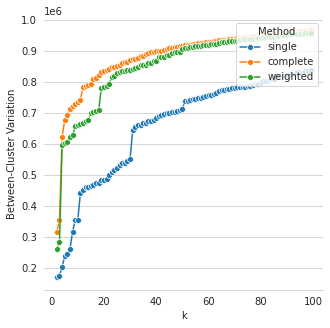

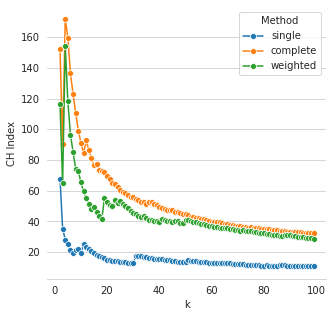

In [95]:
results_df = pd.read_csv(os.path.join(output_path,'results','ch_hier_clust_before_dim_red.csv'))

plt.figure(figsize=[5,5])
sns.lineplot(x='k', y='WCSS', marker='o', hue='method', data=results_df)
plt.xlabel('k')
plt.ylabel('Within-Cluster Variation')
plt.grid(axis='x')
plt.legend(labels=results_df['method'].unique(), title='Method', loc='upper right')
plt.savefig(os.path.join(output_path,'charts','ch_wcss_hier_clust_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

plt.figure(figsize=[5,5])
sns.lineplot(x='k', y='BCSS', marker='o', hue='method', data=results_df)
plt.xlabel('k')
plt.ylabel('Between-Cluster Variation')
plt.grid(axis='x')
plt.legend(labels=results_df['method'].unique(), title='Method', loc='upper right')
plt.savefig(os.path.join(output_path,'charts','ch_bcss_hier_clust_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

plt.figure(figsize=[5,5])
sns.lineplot(x='k', y='CH_index', marker='o', hue='method', data=results_df)
plt.xlabel('k')
plt.ylabel('CH Index')
plt.grid(axis='x')
plt.legend(labels=results_df['method'].unique(), title='Method', loc='upper right')
plt.savefig(os.path.join(output_path,'charts','report_ch_hier_clust_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

In [96]:
results_df = pd.read_csv(os.path.join(output_path,'results','ch_hier_clust_before_dim_red.csv'))
results_df.loc[results_df.groupby('method')['CH_index'].idxmax()]

,method,k,WCSS,BCSS,CH_index
100,complete,4,420699.671496,622640.553424,171.681390
0,single,2,873959.232744,169380.992177,67.833081
198,weighted,4,447376.216488,595964.008433,154.527269


### Average Silhoutte Value

In [97]:
# Initialize variables
K_max = 100
K = range(2,K_max)
method_values = ['single','complete','weighted']
results = []
for method in tqdm(method_values):
    links = linkage(X, method=method, metric='cityblock')

    #for k in tqdm(K):
    for k in K:
        cluster_labels = cut_tree(links, n_clusters=k)
        silhouette_avg_k = silhouette_score(X, cluster_labels.ravel(), metric='cityblock')
        results.append([method,k,silhouette_avg_k])

results_df = pd.DataFrame(results, columns=['method', 'k', 'silhouette_avg'])
results_df.to_csv(os.path.join(output_path,'results','silhouette_hier_clust_before_dim_red.csv'), index=None, header=True)

100%|█████████████████████████████████████████████| 3/3 [00:17<00:00,  5.99s/it]


In [98]:
results_df = pd.read_csv(os.path.join(output_path,'results','silhouette_hier_clust_before_dim_red.csv'))
results_df.loc[results_df.groupby('method')['silhouette_avg'].idxmax()]

,method,k,silhouette_avg
98,complete,2,0.657792
0,single,2,0.776836
196,weighted,2,0.703421
